In [1]:
pip install pymc arviz pandas numpy scipy matplotlib hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 5.4 MB/s eta 0:00:00


Bayesian Linear Regression

In [4]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz as az
import pickle
import joblib

class BayesianLinearRegression:
    def __init__(self):
        self.model = None
        self.trace = None
        self.data = None

    def create_synthetic_data(self, n_samples=100, gravity_condition='earth'):
        """Create synthetic data including gravity variations"""
        np.random.seed(42)

        # Define gravity conditions
        gravity_dict = {
            'space': 0.0,
            'moon': 1.62,
            'mars': 3.72,
            'earth': 9.81,
            'takeoff': 4 * 9.81,  # 4G during takeoff (≈39.24 m/s²)
            'reentry': 6 * 9.81   # 6G during reentry (≈58.86 m/s²)
        }

        gravity_value = gravity_dict[gravity_condition]

        # Handle scalar vs. array cases for gravity_value
        if np.isscalar(gravity_value):
            gravity_arr = np.ones(n_samples) * gravity_value
            linear_accel = np.random.normal(gravity_value, 0.5, n_samples)
            head_tilt = np.random.uniform(-15, 15, n_samples)
            hrv = np.random.uniform(20, 100, n_samples)
            emg = np.random.uniform(20 * (gravity_value / 9.81), 60 * (gravity_value / 9.81), n_samples)
            sway = np.random.uniform(5 * (gravity_value / 9.81), 10 * (gravity_value / 9.81), n_samples)
            # Compute stride_length and stride_freq only if gravity_value > 0
            lower_stride = 1.2 * np.sqrt(9.81 / gravity_value) if gravity_value > 0 else 0
            upper_stride = 1.5 * np.sqrt(9.81 / gravity_value) if gravity_value > 0 else 0
            stride_length = np.random.uniform(lower_stride, upper_stride, n_samples)
            lower_stride_freq = 1.1 * np.sqrt(gravity_value / 9.81) if gravity_value > 0 else 0
            upper_stride_freq = 1.4 * np.sqrt(gravity_value / 9.81) if gravity_value > 0 else 0
            stride_freq = np.random.uniform(lower_stride_freq, upper_stride_freq, n_samples)
        else:
            # If gravity_value were an array (not applicable now, but kept for flexibility)
            gravity_arr = gravity_value  # Already an array of length n_samples
            linear_accel = np.random.normal(gravity_arr, 0.5)
            head_tilt = np.random.uniform(-15, 15, n_samples)
            hrv = np.random.uniform(20, 100, n_samples)
            emg = np.random.uniform(20 * (gravity_arr / 9.81), 60 * (gravity_arr / 9.81))
            sway = np.random.uniform(5 * (gravity_arr / 9.81), 10 * (gravity_arr / 9.81))
            lower_stride = 1.2 * np.sqrt(9.81 / gravity_arr)
            upper_stride = 1.5 * np.sqrt(9.81 / gravity_arr)
            stride_length = np.array([np.random.uniform(l, u) for l, u in zip(lower_stride, upper_stride)])
            lower_stride_freq = 1.1 * np.sqrt(gravity_arr / 9.81)
            upper_stride_freq = 1.4 * np.sqrt(gravity_arr / 9.81)
            stride_freq = np.array([np.random.uniform(l, u) for l, u in zip(lower_stride_freq, upper_stride_freq)])

        time_arr = np.linspace(0, 1, n_samples)

        # Create the data dictionary
        data = {
            'gravity': gravity_arr,
            'linear_accel': linear_accel,
            'head_tilt': head_tilt,
            'hrv': hrv,
            'emg': emg,
            'sway': sway,
            'stride_length': stride_length,
            'stride_freq': stride_freq,
            'time': time_arr
        }

        # Simulate awareness score (target variable)
        awareness = (
            2.0 +  # baseline
            0.3 * linear_accel +
            0.2 * head_tilt +
            0.1 * hrv +
            0.15 * emg +
            -0.1 * sway +
            0.05 * stride_length * stride_freq +  # interaction term
            np.random.normal(0, 0.5, n_samples)  # noise
        )

        data['awareness'] = awareness
        self.data = pd.DataFrame(data)
        return self.data

    def build_and_train_model(self, data=None):
        """Build and train the Bayesian Linear Regression model(with some hope)"""
        if data is not None:
            self.data = data

        with pm.Model() as model:
            # Priors
            intercept = pm.Normal("intercept", mu=0, sigma=10)
            beta_accel = pm.Normal("beta_accel", mu=0, sigma=1)
            beta_tilt = pm.Normal("beta_tilt", mu=0, sigma=1)
            beta_hrv = pm.Normal("beta_hrv", mu=0, sigma=1)
            beta_emg = pm.Normal("beta_emg", mu=0, sigma=1)
            beta_sway = pm.Normal("beta_sway", mu=0, sigma=1)
            beta_stride = pm.Normal("beta_stride", mu=0, sigma=1)
            beta_time = pm.Normal("beta_time", mu=0, sigma=1)

            # Interaction term
            beta_stride_interaction = pm.Normal("beta_stride_interaction", mu=0, sigma=1)

            # Error term
            sigma = pm.HalfNormal("sigma", sigma=1)

            # Expected value
            mu = (intercept +
                  beta_accel * self.data['linear_accel'] +
                  beta_tilt * self.data['head_tilt'] +
                  beta_hrv * self.data['hrv'] +
                  beta_emg * self.data['emg'] +
                  beta_sway * self.data['sway'] +
                  beta_stride * self.data['stride_length'] +
                  beta_time * self.data['time'] +
                  beta_stride_interaction * self.data['stride_length'] * self.data['stride_freq'])

            # Likelihood
            y = pm.Normal("y", mu=mu, sigma=sigma, observed=self.data['awareness'])

            # Sampling
            trace = pm.sample(2000, tune=1000, return_inferencedata=True)

        self.model = model
        self.trace = trace
        return model, trace

    def analyze_results(self):
        """Analyze and plot BLR results"""
        if self.trace is None:
            raise ValueError("Model hasn't been trained yet. Call build_and_train_model first.")

        # Summary statistics
        summary = az.summary(self.trace)
        print("\nModel Summary:")
        print(summary)

        # Plot posterior distributions
        az.plot_posterior(self.trace)
        plt.tight_layout()
        plt.show()

        # Plot trace plots
        az.plot_trace(self.trace)
        plt.tight_layout()
        plt.show()

        return summary

    def save_model(self, filepath):
        """Save the model and trace"""
        if self.model is None or self.trace is None:
            raise ValueError("Model hasn't been trained yet. Call build_and_train_model first.")

        # Save model, trace, and data
        model_data = {
            'data': self.data,
            'trace': self.trace
        }

        # Save using arviz
        self.trace.to_netcdf(filepath + '_trace.nc')
        # Save data using joblib
        joblib.dump(self.data, filepath + '_data.joblib')

    @classmethod
    def load_model(cls, filepath):
        """Load the saved model and trace"""
        instance = cls()

        # Load trace using arviz
        instance.trace = az.from_netcdf(filepath + '_trace.nc')
        # Load data using joblib
        instance.data = joblib.load(filepath + '_data.joblib')

        return instance

    def predict(self, new_data):
        """Make predictions using the trained model"""
        if self.trace is None:
            raise ValueError("Model hasn't been trained yet. Call build_and_train_model first.")

        # Get posterior means
        posterior_means = az.summary(self.trace)['mean']

        # Calculate prediction using the posterior means
        prediction = (
            posterior_means['intercept'] +
            posterior_means['beta_accel'] * new_data['linear_accel'] +
            posterior_means['beta_tilt'] * new_data['head_tilt'] +
            posterior_means['beta_hrv'] * new_data['hrv'] +
            posterior_means['beta_emg'] * new_data['emg'] +
            posterior_means['beta_sway'] * new_data['sway'] +
            posterior_means['beta_stride'] * new_data['stride_length'] +
            posterior_means['beta_time'] * new_data['time'] +
            posterior_means['beta_stride_interaction'] * new_data['stride_length'] * new_data['stride_freq']
        )

        return prediction

    def predict_for_gravity(self, gravity_condition, n_samples=100):
        """
        Generate synthetic data for a given gravity condition and predict awareness.
        Temporarily saves the original training data and restores it after prediction.
        """
        # Backup the original training data
        original_data = self.data.copy() if self.data is not None else None

        # Generate new synthetic test data for the specified gravity condition
        test_data = self.create_synthetic_data(n_samples=n_samples, gravity_condition=gravity_condition)
        predictions = self.predict(test_data)

        # Optionally, restore the original training data
        if original_data is not None:
            self.data = original_data

        return predictions

    def analyze_gravity_conditions(self, conditions, n_samples=100):
        """
        Compare the predicted awareness distributions across different gravity conditions.
        Generates predictions for each condition and plots the distributions.
        """
        predictions_dict = {}

        for condition in conditions:
            preds = self.predict_for_gravity(gravity_condition=condition, n_samples=n_samples)
            predictions_dict[condition] = preds

        # Plot histograms for each gravity condition
        plt.figure(figsize=(10, 6))
        for condition, preds in predictions_dict.items():
            plt.hist(preds, bins=20, alpha=0.5, label=condition)
        plt.xlabel("Predicted Awareness")
        plt.ylabel("Frequency")
        plt.title("Predicted Awareness Distribution Across Gravity Conditions")
        plt.legend()
        plt.tight_layout()
        plt.show()

        return predictions_dict

Output()

Output()


Model Summary:
                          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_accel               0.406  0.121   0.180    0.632      0.002    0.002   
beta_emg                 0.151  0.005   0.143    0.160      0.000    0.000   
beta_hrv                 0.098  0.003   0.093    0.103      0.000    0.000   
beta_stride              0.825  0.683  -0.446    2.127      0.012    0.010   
beta_stride_interaction -0.752  0.392  -1.502   -0.049      0.007    0.005   
beta_sway               -0.161  0.036  -0.228   -0.095      0.001    0.000   
beta_tilt                0.185  0.007   0.172    0.199      0.000    0.000   
beta_time                0.018  0.187  -0.326    0.378      0.003    0.003   
intercept                1.768  1.482  -1.019    4.508      0.033    0.023   
sigma                    0.533  0.041   0.460    0.610      0.001    0.000   

                         ess_bulk  ess_tail  r_hat  
beta_accel                 2912.0    2828.0    1.0  
beta_emg           

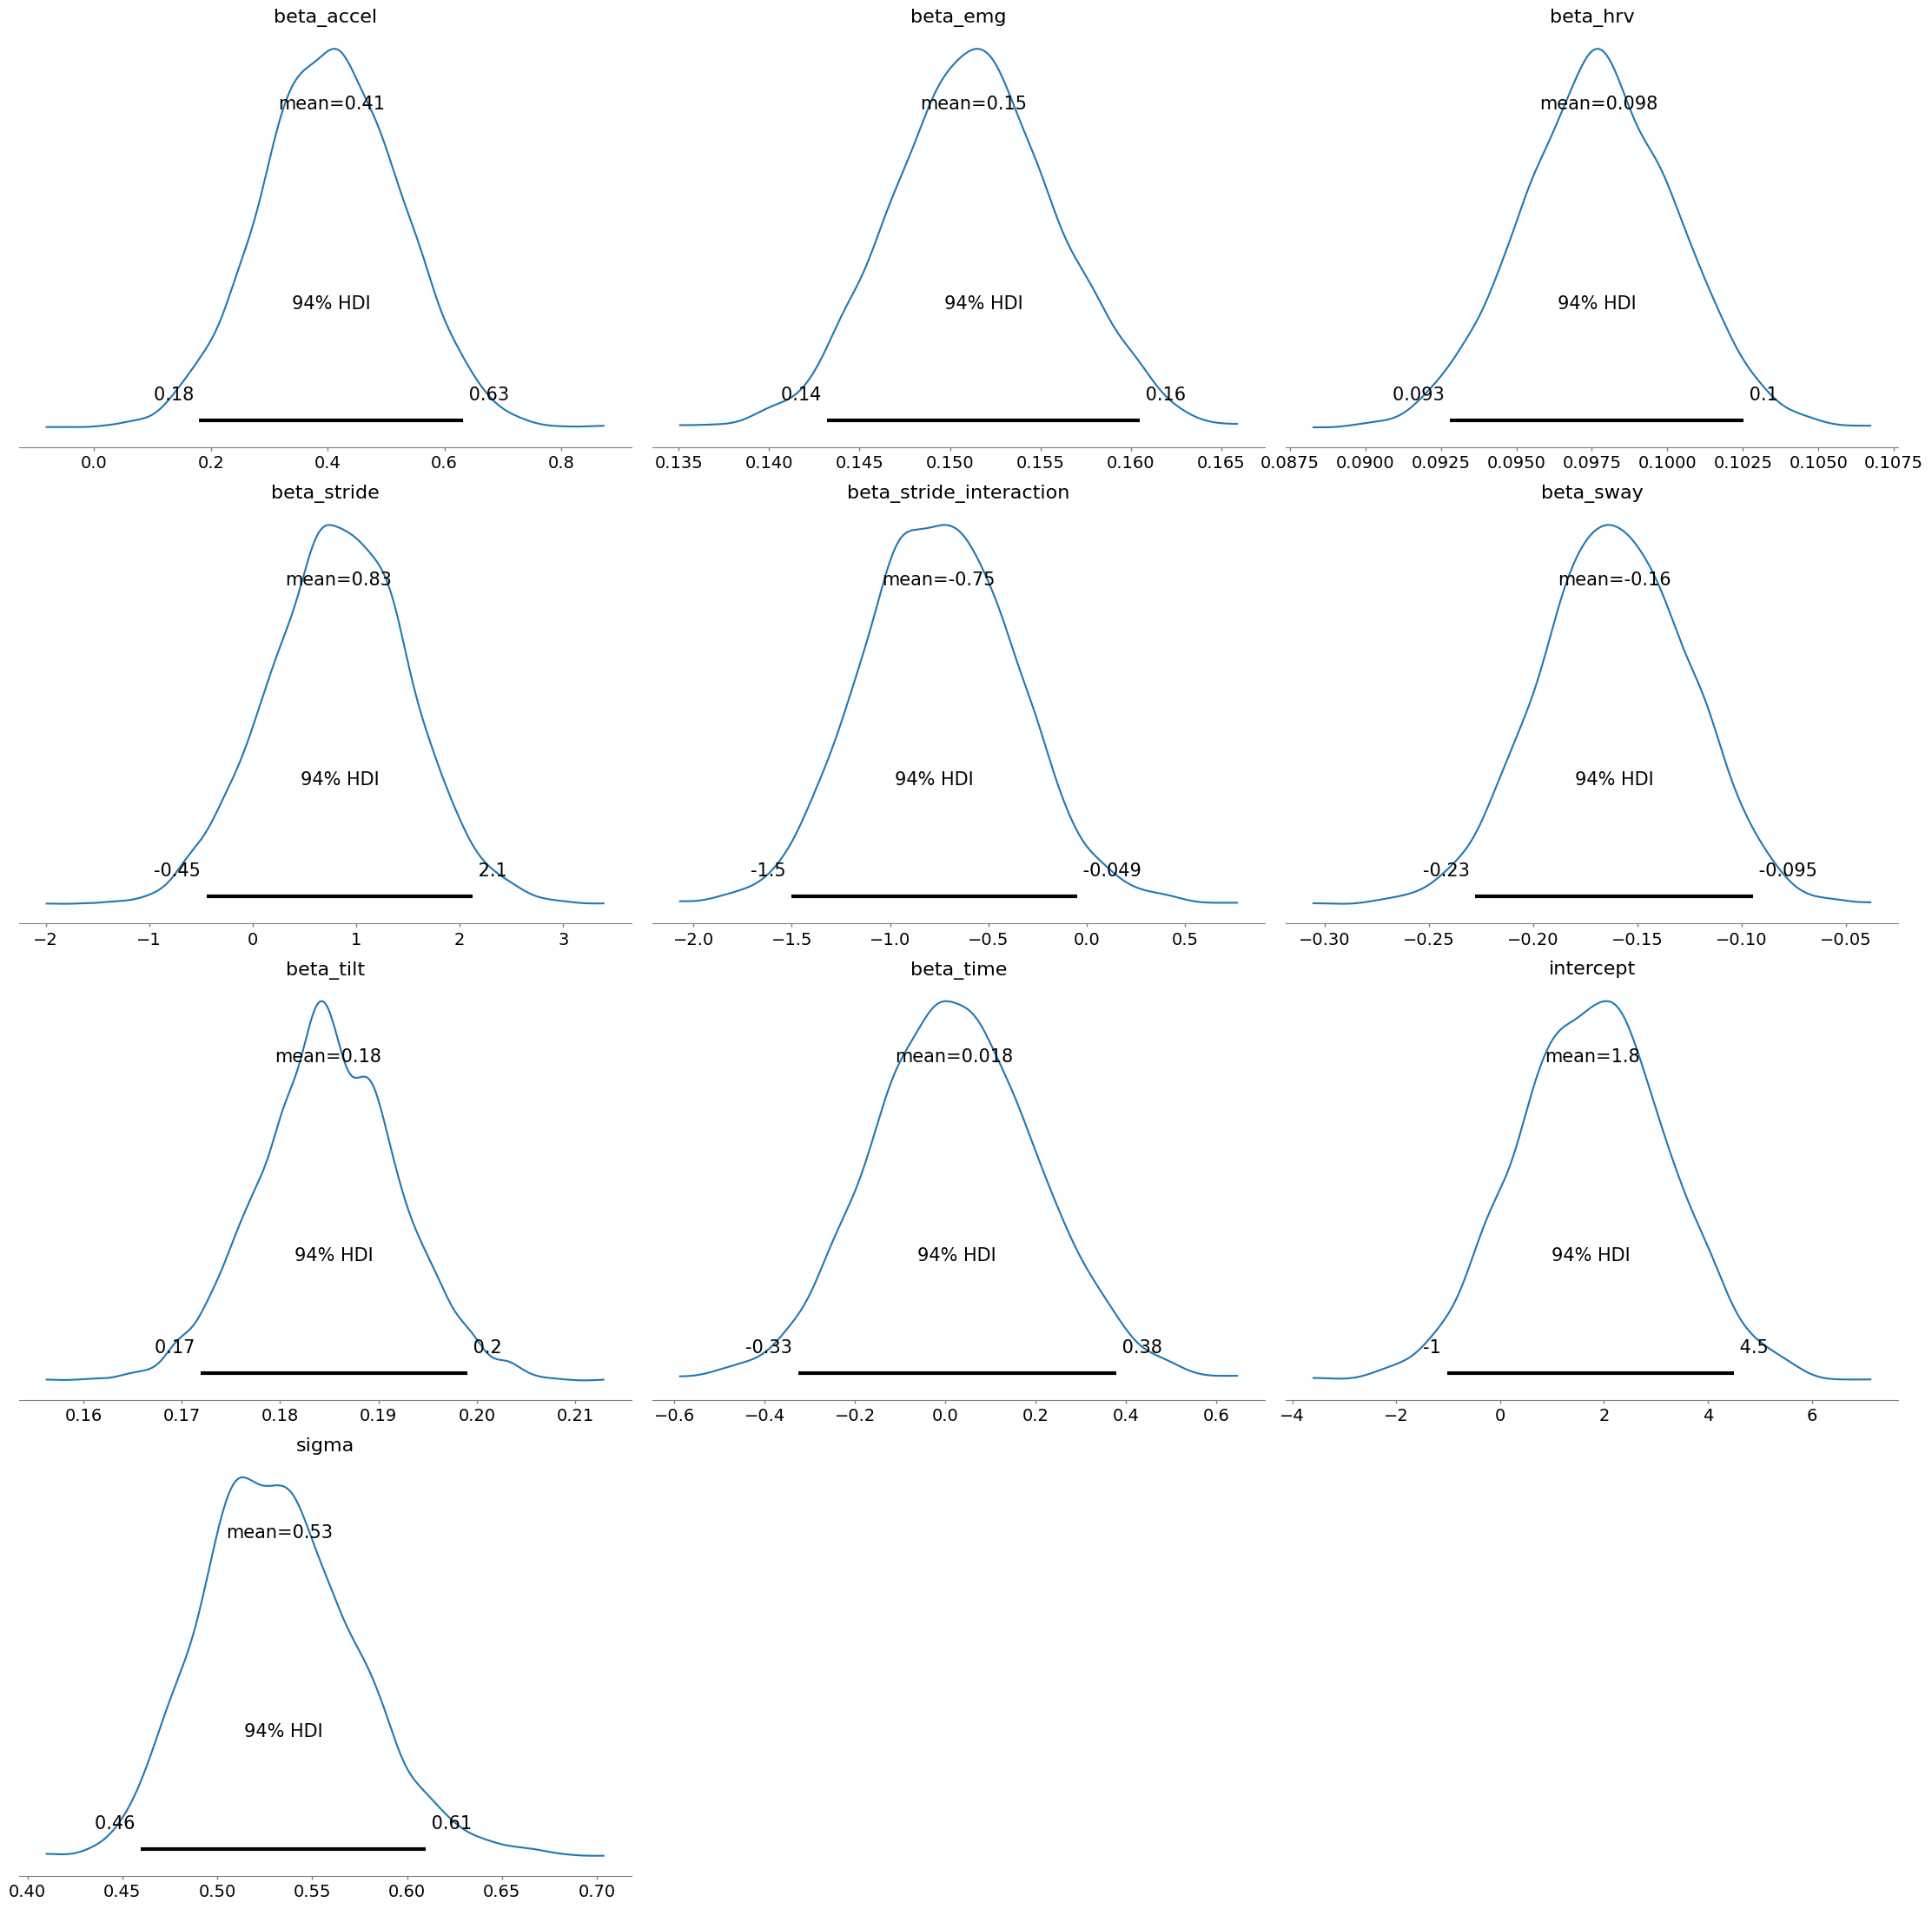

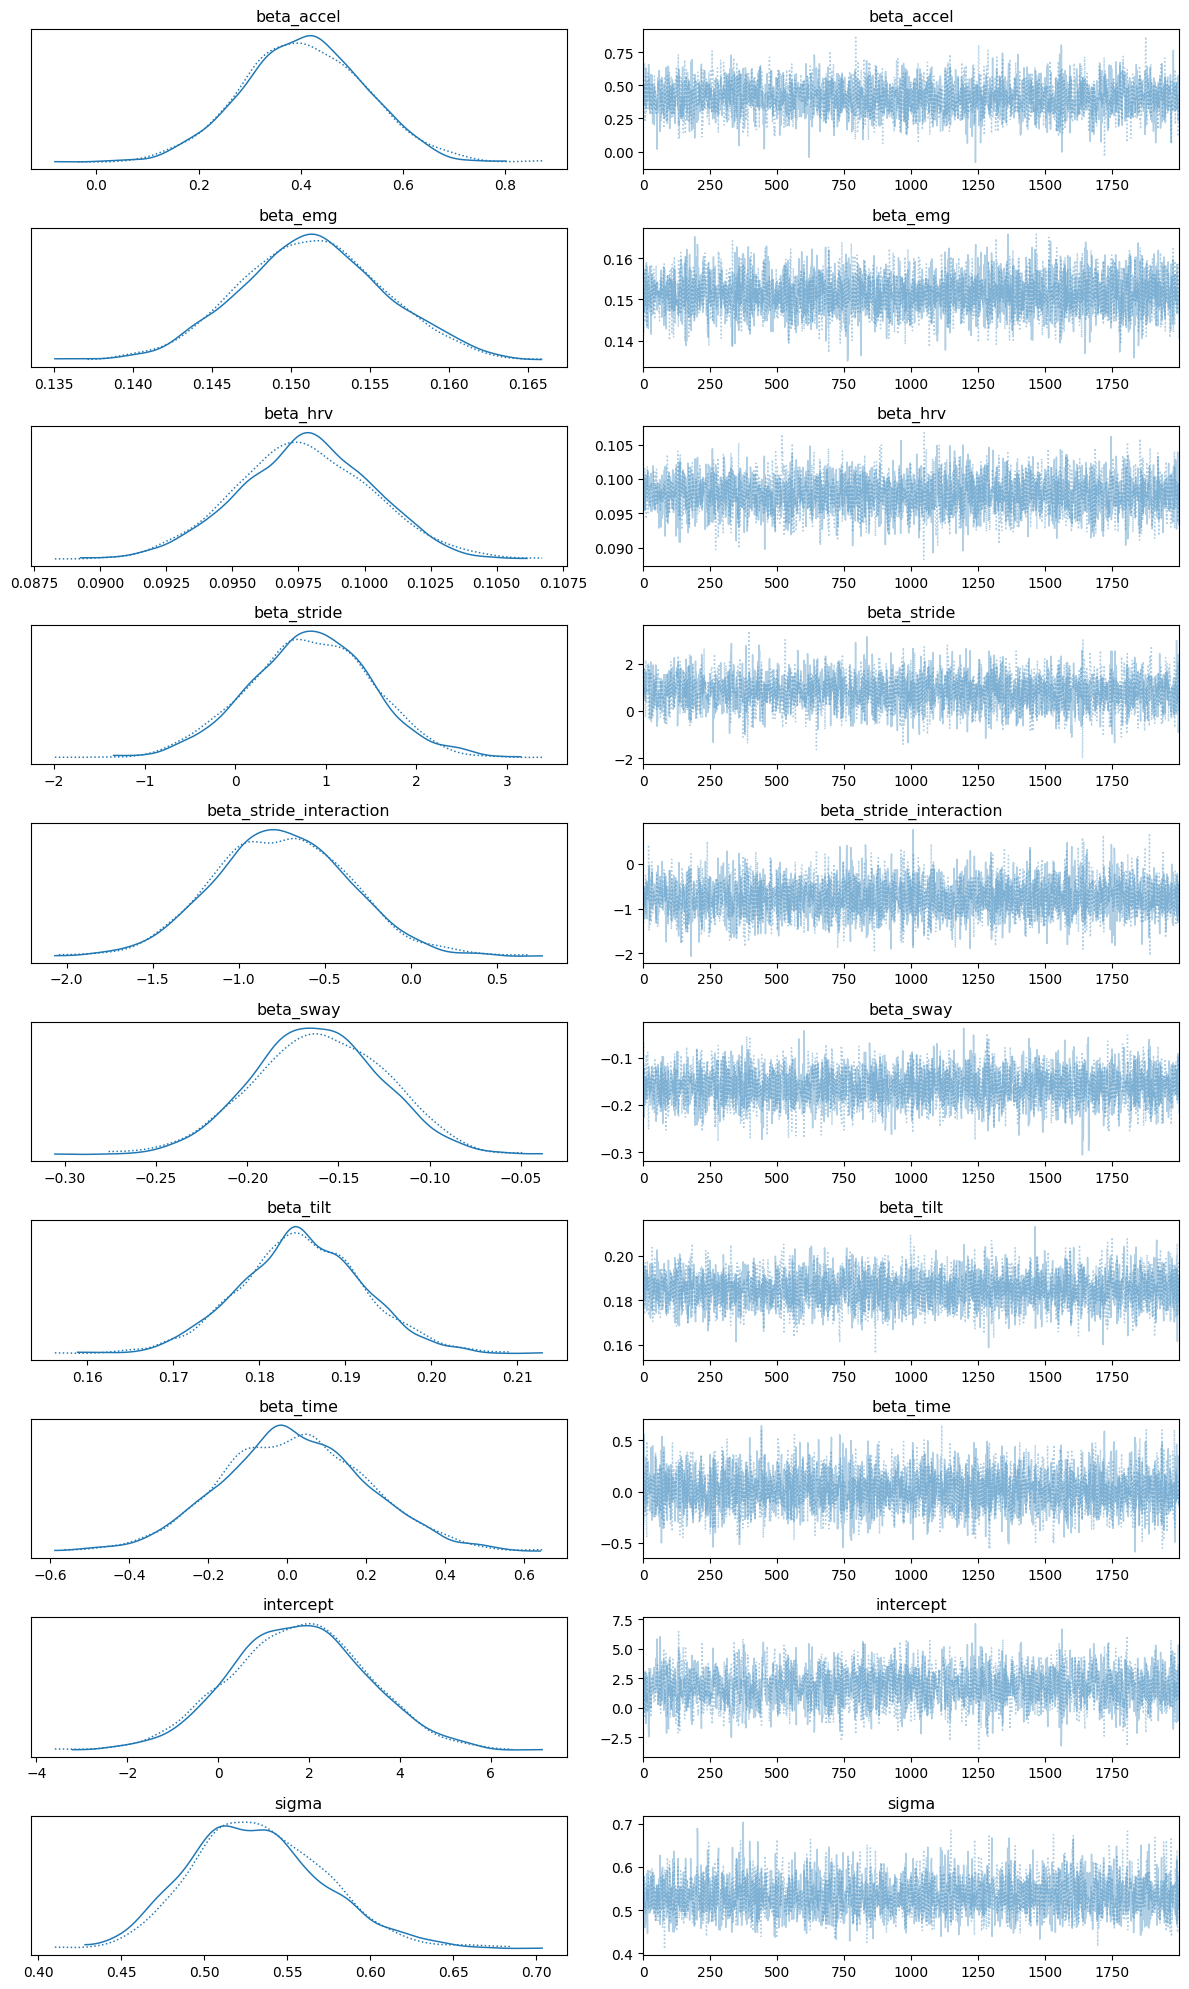

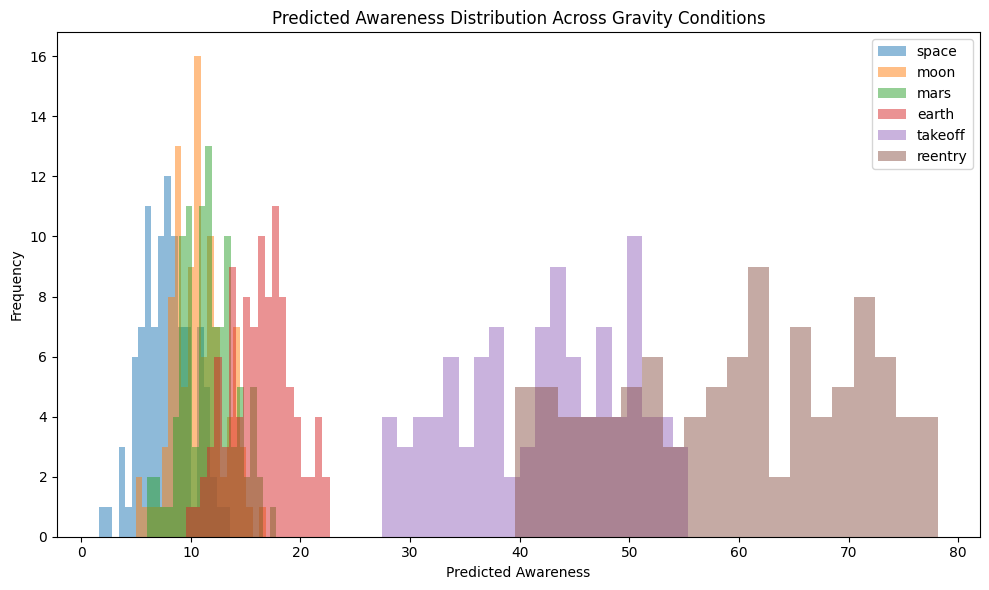


Mean Awareness Predictions by Gravity Condition:
Space   : Mean = 7.78 ± 2.29
Moon    : Mean = 10.70 ± 2.29
Mars    : Mean = 11.65 ± 2.36
Earth   : Mean = 16.39 ± 2.86
Takeoff : Mean = 42.09 ± 7.50
Reentry : Mean = 59.49 ± 11.00


In [8]:
if __name__ == "__main__":
    # Initialize the model
    blr = BayesianLinearRegression()

    # Create synthetic data for training (using 'earth' gravity as an example)
    train_data = blr.create_synthetic_data(n_samples=100, gravity_condition='earth')

    # Build and train the model
    model, trace = blr.build_and_train_model(data=train_data)

    # Analyze training results
    blr.analyze_results()

    # Now, analyze the predicted awareness in different gravity conditions
    conditions = ['space', 'moon', 'mars', 'earth', 'takeoff', 'reentry']
    predictions_by_gravity = blr.analyze_gravity_conditions(conditions=conditions, n_samples=100)

    # Print out mean predictions for each gravity condition
    print("\nMean Awareness Predictions by Gravity Condition:")
    print("=" * 45)
    for condition, preds in predictions_by_gravity.items():
        mean_awareness = np.mean(preds)
        std_awareness = np.std(preds)
        print(f"{condition.capitalize():8}: Mean = {mean_awareness:.2f} ± {std_awareness:.2f}")

Dynamic Bayesian Network

Training DBN on 3 sequences...
Model saved to dbn_gravity_model.joblib
Model loaded from dbn_gravity_model.joblib

=== DBN Demo ===
Test Sequence: ['highly_alert', 'normal_alert', 'slightly_drowsy', 'normal_alert']
Predicted States: ['predicted_highly_alert', 'predicted_normal_alert', 'predicted_slightly_drowsy', 'predicted_normal_alert']
Log Probability: -4
Sequence Analysis:
  Input Sequence:  ['highly_alert', 'normal_alert', 'slightly_drowsy', 'normal_alert']
  Predicted States:  ['predicted_highly_alert', 'predicted_normal_alert', 'predicted_slightly_drowsy', 'predicted_normal_alert']
  Log Probability:  -4


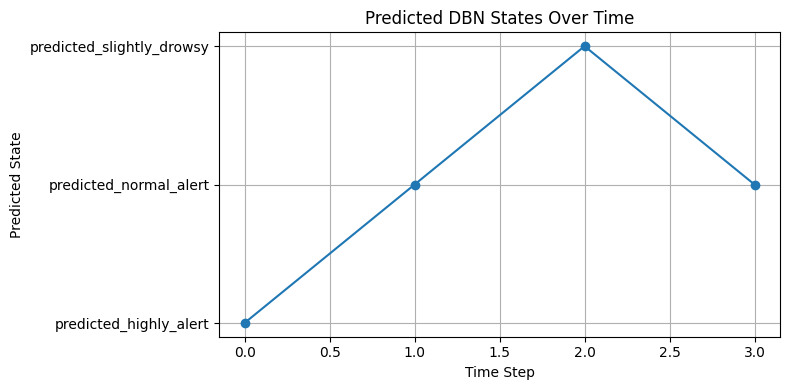

In [ ]:
import matplotlib.pyplot as plt
import joblib

class GravityAwarenessDBN:
    def __init__(self):
        # Initialize your DBN parameters here.
        # For example, initialize state transition probabilities, emission probabilities, etc.
        self.model = None  # This would be your internal representation (e.g., a dictionary or a DBN object from a library)
        self.trained = False

    def train(self, training_sequences):
        """
        Train the DBN on a list of training sequences.
        Each sequence is a list of state strings (e.g., 'highly_alert', 'normal_alert', etc.)
        """
        # Insert training logic here:
        # For example, estimate transition probabilities and emission probabilities from the training data.
        print("Training DBN on {} sequences...".format(len(training_sequences)))
        # (Dummy training logic – replace with actual training code)
        self.model = {"transitions": {}, "emissions": {}}
        self.trained = True

    def save_model(self, filepath):
        """Save the DBN model using joblib."""
        if not self.trained:
            raise ValueError("The model is not trained yet!")
        joblib.dump(self.model, filepath)
        print("Model saved to", filepath)

    @classmethod
    def load_model(cls, filepath):
        """Load a saved DBN model."""
        instance = cls()
        instance.model = joblib.load(filepath)
        instance.trained = True
        print("Model loaded from", filepath)
        return instance

    def predict(self, sequence):
        """
        Given a sequence, predict the hidden states.
        (In a real DBN, you might use the Viterbi algorithm here.)
        For this example, we'll return a dummy list of predictions.
        """
        if not self.trained:
            raise ValueError("Model is not trained. Please train the model before prediction.")
        # Dummy prediction logic (replace with your inference algorithm)
        predicted_states = ["predicted_" + state for state in sequence]
        return predicted_states

    def get_log_probability(self, sequence):
        """
        Calculate the log probability of a given sequence.
        (This would typically involve a forward algorithm or similar.)
        """
        if not self.trained:
            raise ValueError("Model is not trained. Please train the model before computing log probability.")
        # Dummy log probability (replace with actual computation)
        log_prob = -len(sequence)  # Dummy value
        return log_prob

    def analyze_sequence(self, sequence):
        """
        Analyze a given sequence by printing out the predicted states and log probability.
        Additionally, this function plots the predicted states over time.
        """
        predictions = self.predict(sequence)
        log_prob = self.get_log_probability(sequence)
        print("Sequence Analysis:")
        print("  Input Sequence: ", sequence)
        print("  Predicted States: ", predictions)
        print("  Log Probability: ", log_prob)

        # Call the plotting function to visualize the predictions
        self.plot_predictions(sequence, predictions)

        return predictions, log_prob

    def plot_predictions(self, sequence, predictions):
        """
        Plot the predicted states over time. This method converts the state labels into integer values for plotting.
        """
        # Create a mapping from unique predicted states to integer indices
        unique_states = sorted(set(predictions))
        state_to_int = {state: i for i, state in enumerate(unique_states)}
        pred_ints = [state_to_int[state] for state in predictions]

        plt.figure(figsize=(8, 4))
        plt.plot(range(len(pred_ints)), pred_ints, marker='o', linestyle='-')
        plt.yticks(list(state_to_int.values()), list(state_to_int.keys()))
        plt.xlabel('Time Step')
        plt.ylabel('Predicted State')
        plt.title('Predicted DBN States Over Time')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def dbn_demo():
    # Create and train the DBN model
    dbn_model = GravityAwarenessDBN()

    # Example training sequences (list of sequences)
    training_sequences = [
        ['highly_alert', 'normal_alert', 'slightly_drowsy', 'normal_alert'],
        ['normal_alert', 'normal_alert', 'highly_alert', 'normal_alert'],
        ['slightly_drowsy', 'very_drowsy', 'slightly_drowsy', 'normal_alert']
    ]

    # Train the model
    dbn_model.train(training_sequences)

    # Save the model (use consistent file naming)
    save_filename = 'dbn_gravity_model.joblib'
    dbn_model.save_model(save_filename)

    # Load the model from the same file
    loaded_dbn = GravityAwarenessDBN.load_model(save_filename)

    # Test sequence for prediction
    test_sequence = ['highly_alert', 'normal_alert', 'slightly_drowsy', 'normal_alert']

    # Make predictions and get log probability
    predictions = loaded_dbn.predict(test_sequence)
    log_prob = loaded_dbn.get_log_probability(test_sequence)

    print("\n=== DBN Demo ===")
    print("Test Sequence:", test_sequence)
    print("Predicted States:", predictions)
    print("Log Probability:", log_prob)

    # Analyze the test sequence (this will also generate a plot)
    loaded_dbn.analyze_sequence(test_sequence)


if __name__ == '__main__':
    dbn_demo()
